# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize
from imageio import imread

import cv2

In [25]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.regularizers import l2

from keras.optimizers import Nadam, Adam, SGD

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -q '/content/gdrive/MyDrive/Project_data.zip' -d '/content/gdrive/MyDrive'

In [28]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/val.csv').readlines())
batch_size = 25 #experiment with the batch size

In [5]:
sample_image = os.listdir('/content/gdrive/MyDrive/Project_data/train'+'/'+ np.random.permutation(train_doc)[0 + (0)].split(';')[0])

In [6]:
print(sample_image)

['WIN_20180926_17_24_58_Pro_00051.png', 'WIN_20180926_17_24_58_Pro_00041.png', 'WIN_20180926_17_24_58_Pro_00009.png', 'WIN_20180926_17_24_58_Pro_00025.png', 'WIN_20180926_17_24_58_Pro_00027.png', 'WIN_20180926_17_24_58_Pro_00045.png', 'WIN_20180926_17_24_58_Pro_00015.png', 'WIN_20180926_17_24_58_Pro_00061.png', 'WIN_20180926_17_24_58_Pro_00031.png', 'WIN_20180926_17_24_58_Pro_00023.png', 'WIN_20180926_17_24_58_Pro_00017.png', 'WIN_20180926_17_24_58_Pro_00007.png', 'WIN_20180926_17_24_58_Pro_00029.png', 'WIN_20180926_17_24_58_Pro_00011.png', 'WIN_20180926_17_24_58_Pro_00063.png', 'WIN_20180926_17_24_58_Pro_00057.png', 'WIN_20180926_17_24_58_Pro_00053.png', 'WIN_20180926_17_24_58_Pro_00019.png', 'WIN_20180926_17_24_58_Pro_00065.png', 'WIN_20180926_17_24_58_Pro_00047.png', 'WIN_20180926_17_24_58_Pro_00035.png', 'WIN_20180926_17_24_58_Pro_00043.png', 'WIN_20180926_17_24_58_Pro_00013.png', 'WIN_20180926_17_24_58_Pro_00033.png', 'WIN_20180926_17_24_58_Pro_00055.png', 'WIN_20180926_17_24_58_P

In [7]:
sample_path = '/content/gdrive/MyDrive/Project_data/train'+'/'+ train_doc[0].split(';')[0]
sample = imread(sample_path+'/'+os.listdir(sample_path)[0])

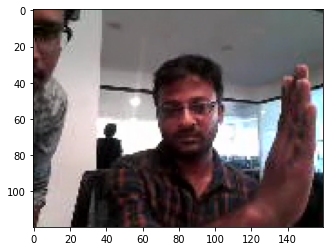

In [8]:
plt.imshow(sample)
plt.show()

In [9]:
sample.shape

(120, 160, 3)

In [10]:
img_height = 120
img_width = 120
channels = 3

In [11]:
num_classes = 5
print ('# classification classes =', num_classes)

# classification classes = 5


In [12]:
sample = resize(sample,(img_height,img_width,3))

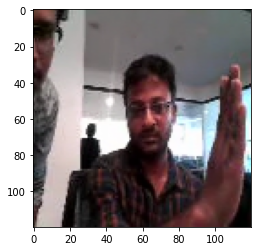

In [13]:
plt.imshow(sample)
plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [14]:
# Parameters initialization
no_of_rows = 120   # X dimension of the image
no_of_cols = 120   # Y dimesnion of the image
no_of_frames = 30  # lenght of the video frames
no_of_channels = 3 # numbe of channels in images 3 for color(RGB)

In [15]:
def load_batch_data(source_path, folder_list, batch_size, batch, t, model_type, validation=0):
    if model_type == 'conv3D':
        batch_data = np.zeros((batch_size, no_of_frames, no_of_rows, no_of_cols, no_of_channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3
    else:
        batch_data = np.zeros((batch_size, no_of_rows, no_of_cols, no_of_channels))
    #print(batch_data.shape)
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    img_idx = list(range(0,30,1)) #create a list of image numbers you want to use for a particular video
    
    for folder in range(batch_size): # iterate over the batch_size        
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
               
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
           
            image = cv2.resize(image, (no_of_rows,no_of_cols), interpolation = cv2.INTER_AREA)
            
            normalizedImg = np.zeros((120, 120, 3))
            normalizedImg = cv2.normalize(image, np.zeros((120, 120,3)) , 0, 1, cv2.NORM_MINMAX)
            #print(normalizedImg.shape)
            
            if model_type == 'conv3D':
                batch_data[folder,idx] = normalizedImg #normalise and feed in the image
            else:
                batch_data[folder] = normalizedImg
         
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #print(batch_data.shape)
            
    return (batch_data,batch_labels)


def generator(source_path, folder_list, batch_size, model_type, validation=0):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    while True:
        # t contains list of file name
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield load_batch_data(source_path, folder_list, batch_size, batch, t, model_type) #you yield the batch_data and the batch_labels, remember what does yield do

        # code for the remaining data points which are left after full batches
        remainder = len(folder_list) % batch_size
        if (remainder > 0):
            batch_size = remainder
            yield load_batch_data(source_path, folder_list, batch_size, batch, t, model_type) #you yield the batch_data and the batch_labels, remember what does yield do

# For CNN+RNN

Please select further lesser no of images as the computation part is going to be too heavy. My advice will be to select 12 to 14 images.

Rest all of the above code will remain the same.

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

__Why are we using datetime?__

Because we will be creating multiple models and we dont wish to overwrite a new model over the older one. Therefore, saving it along with the timestamp helps.

In [17]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/Project_data/train'
val_path = '/content/gdrive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 35 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 35


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [43]:
train_generator = generator(train_path, train_doc, 25, 'conv3D')
val_generator = generator(val_path, val_doc, 25, 'conv3D')

In [44]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1) #write the REducelronplateau code here
callbacks_list = [checkpoint, LR, earlystop]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [45]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### CONV3D

In [46]:
#write your model here

no_of_rows = 120   # X dimension of the image
no_of_cols = 120   # Y dimesnion of the image
no_of_frames = 30  # lenght of the video frames
no_of_channels = 3 # numbe of channels in images 3 for color(RGB)

# Input
input_shape=(no_of_frames, no_of_rows, no_of_cols, no_of_channels)

# Define model
def conv3d_model():
    model = Sequential()

    model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(5, activation='softmax'))
    
    return model

In [47]:
from keras.optimizers import Nadam, Adam, SGD
# optimiser = Adam() #write your optimizer
optimiser = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model = conv3d_model()
model.compile(optimizer=optimiser, loss='mean_squared_error', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_4 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_5 (Activation)    (None, 15, 60, 60, 16)   

In [48]:
num_epochs = 25
history1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 25
Epoch 1/25
27/27 [==============================] - 751s 28s/step - loss: 1.9254 - categorical_accuracy: 0.2096 - val_loss: 1.7474 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2021-05-1010_04_06.508261/model-00001-1.87956-0.22172-1.74742-0.30000.h5
Epoch 2/25
27/27 [==============================] - 418s 16s/step - loss: 1.7176 - categorical_accuracy: 0.2574 - val_loss: 1.5836 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2021-05-1010_04_06.508261/model-00002-1.67534-0.25926-1.58357-0.26000.h5
Epoch 3/25
27/27 [==============================] - 417s 16s/step - loss: 1.5486 - categorical_accuracy: 0.2146 - val_loss: 1.4336 - val_categorical_accuracy: 0.3400

Epoch 00003: saving model to model_init_2021-05-1010_04_06.508261/model-00003-1.51014-0.26211-1.43362-0.34000.h5
Epoch 4/25
27/27 [==============================] - 415s 15s/step - loss: 1.3984 - c

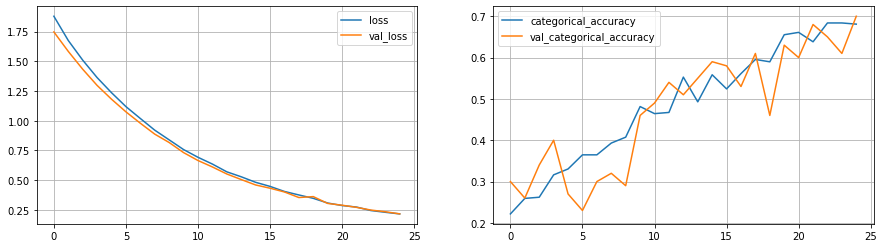

In [49]:
plot(history1)

Observation: Best accuracy and stability observed as per alll other models tried. Categorical accuracy - 0.72 and validation accuracy 0.71 with loss as low as ~0.2

###CONV3D (elu)

In [23]:
#write your model here

no_of_rows = 120   # X dimension of the image
no_of_cols = 120   # Y dimesnion of the image
no_of_frames = 30  # lenght of the video frames
no_of_channels = 3 # numbe of channels in images 3 for color(RGB)

# Input
input_shape=(no_of_frames, no_of_rows, no_of_cols, no_of_channels)

# Define model
def conv3d_model1():
    model = Sequential()

    model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
    model.add(Activation('elu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Flatten())

    model.add(Dense(256, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='elu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(5, activation='softmax'))
    
    return model

In [26]:
#write your optimizer
optimiser = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model1 = conv3d_model1()
model1.compile(optimizer=optimiser, loss='mean_squared_error', metrics=['categorical_accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 16)    0

In [30]:
num_epochs = 25
history2 = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
27/27 [==============================] - 1408s 53s/step - loss: 1.8626 - categorical_accuracy: 0.2324 - val_loss: 1.7340 - val_categorical_accuracy: 0.1800
Epoch 2/25
27/27 [==============================] - 417s 15s/step - loss: 1.6599 - categorical_accuracy: 0.2650 - val_loss: 1.5422 - val_categorical_accuracy: 0.3500
Epoch 3/25
27/27 [==============================] - 415s 15s/step - loss: 1.4828 - categorical_accuracy: 0.3134 - val_loss: 1.4110 - val_categorical_accuracy: 0.2200
Epoch 4/25
27/27 [==============================] - 416s 15s/step - loss: 1.3350 - categorical_accuracy: 0.3561 - val_loss: 1.2400 - val_categorical_accuracy: 0.3900
Epoch 5/25
27/27 [==============================] - 414s 15s/step - loss: 1.1877 - categorical_accuracy: 0.4416 - val_loss: 1.1242 - val_categorical_accuracy: 0.3900
Epoch 6/25
27/27 [==============================] - 417s 15s/step - loss: 1.0757 - categorical_accuracy: 0.4729 - val_loss: 1.0223 - val_categorical_accuracy: 0.4800
Epo

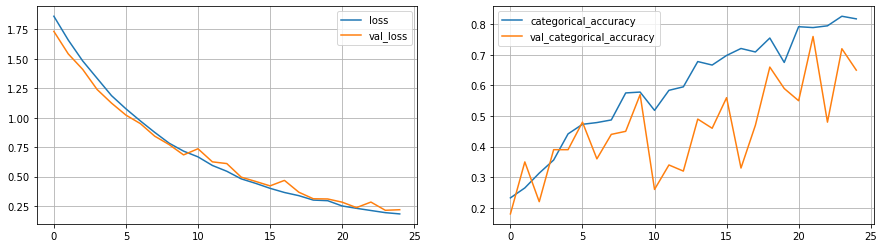

In [31]:
plot(history2)

Observation:- High validation accuracy fluctuation

###CNN-RNN

In [35]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import LSTM, Reshape

#write your model here
no_of_rows1 = 120   # X dimension of the image
no_of_cols1 = 120   # Y dimesnion of the image
no_of_frames1 = 30  # lenght of the video frames
no_of_channels1 = 3 # numbe of channels in images 3 for color(RGB)

# Input
cnn_rnn_input_shape=(no_of_rows1, no_of_cols1, no_of_channels1)

In [36]:
# Transfer Learning with VGGNet
def transfer_vgg16():
    from keras.applications.vgg16 import VGG16
    from keras.applications.resnet50 import ResNet50
    from keras.models import Model
    from keras.layers import Dense, Input
    from keras.layers.pooling import GlobalAveragePooling2D
    from keras.layers.recurrent import LSTM
    from keras.layers.wrappers import TimeDistributed   
    
    vgg16_model = VGG16(weights='imagenet',
                               include_top=False,input_shape=cnn_rnn_input_shape)
    model = Sequential()
    
    for layer in vgg16_model.layers:
        #print(layer)
        model.add(layer)
        
    for layer in vgg16_model.layers:
        layer.trainable = False  #Do not train VGG16 pre-trained layers     
    
    model.add(Flatten())
    #print (model.summary()) 
    
    #dimensions of flattened vector: 4608 obtained by printing model.summary()
    model.add(Reshape((4608,1)))
    
    model.add(GRU(128, input_shape=(30, 4608, 1), return_sequences=True, recurrent_regularizer=l2(0.01))) 
    
    model.add(Flatten())

    model.add(Dense(5, activation='softmax')) 
    
    return model

In [37]:
optimiser1 = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model3 = transfer_vgg16()
model3.compile(loss='mean_squared_error', optimizer=optimiser1, metrics=['categorical_accuracy'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 30, 30, 256)      

In [38]:
train_generator1 = generator(train_path, train_doc, batch_size, 'VGG16_RNN') #change it to cnn-rnn for the cnn-rnn model
val_generator1 = generator(val_path, val_doc, batch_size, 'VGG16_RNN') #change it to cnn-rnn for the cnn-rnn model

In [39]:
model_name1 = 'cnn_rnn_model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name1):
    os.mkdir(model_name1)
      
filepath1 = model_name1 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

earlystop1 = EarlyStopping( monitor="val_loss", min_delta=0,patience=5,verbose=1)

LR1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here

callbacks_list1 = [LR1,earlystop1]

In [40]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch1 = int(num_train_sequences/batch_size)
else:
    steps_per_epoch1 = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps1 = int(num_val_sequences/batch_size)
else:
    validation_steps1 = (num_val_sequences//batch_size) + 1

In [41]:
num_epochs1 = 15
history3 = model3.fit_generator(train_generator1, steps_per_epoch=steps_per_epoch1, epochs=num_epochs1, verbose=1, 
                    callbacks=callbacks_list1, validation_data=val_generator1, 
                    validation_steps=validation_steps1, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 25
Epoch 1/15
27/27 [==============================] - 277s 10s/step - loss: 1.4224 - categorical_accuracy: 0.2108 - val_loss: 1.3383 - val_categorical_accuracy: 0.4800
Epoch 2/15
27/27 [==============================] - 192s 7s/step - loss: 1.3043 - categorical_accuracy: 0.4080 - val_loss: 1.2124 - val_categorical_accuracy: 0.3900
Epoch 3/15
27/27 [==============================] - 188s 7s/step - loss: 1.1793 - categorical_accuracy: 0.4660 - val_loss: 1.0875 - val_categorical_accuracy: 0.5500
Epoch 4/15
27/27 [==============================] - 188s 7s/step - loss: 1.0588 - categorical_accuracy: 0.5619 - val_loss: 0.9804 - val_categorical_accuracy: 0.6100
Epoch 5/15
27/27 [==============================] - 187s 7s/step - loss: 0.9530 - categorical_accuracy: 0.6172 - val_loss: 0.8945 - val_categorical_accuracy: 0.5100
Epoch 6/15
27/27 [==============================] - 188s 7s/step - loss: 0.8593 - categorical_accu

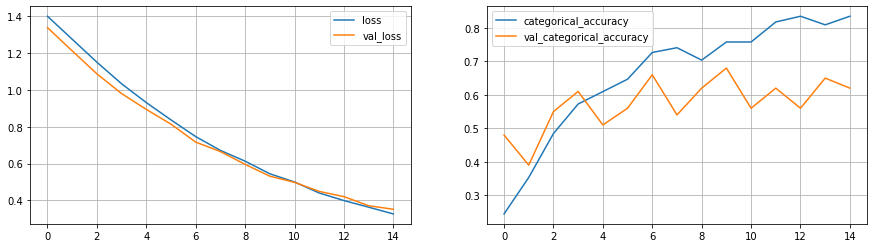

In [42]:
plot(history3)

Observation: Categorical accuracy of ~0.82 and validation categorical accuracy of ~0.62. We can say that the model accuracy will increase with more epochs.

The following code will help you in calculating the accuracy on the test dataset. Please note that the structure in which the test data is stored needs to the same as that of the train or the validation dataset. Choose one of the models saved during training to calculate the test accuracy.

In [ ]:
from keras.models import load_model, Model
#######
    
model_name = '/storage/Final_data/model_init_conv_lstm_2018-10-0316_27_25.831386/model-00041-0.05310-0.99698-0.85627-0.71000.h5'
    
#######

num_test_sequences = len(val_doc)
print ('# testing sequences =', num_test_sequences)
test_generator = generator(val_path, val_doc, batch_size)
model = load_model(model_name)
print("Model loaded.")
model_func = Model(inputs=[model.input], outputs=[model.output])
    
acc = 0
    
num_batches = int(num_test_sequences/batch_size)
    
for i in range(num_batches):
    x,true_labels = test_generator.__next__()
    print ("shape of x:", x.shape, "and shape of true_labels:", true_labels.shape)
    pred_idx = np.argmax(model_func.predict_on_batch(x), axis=1)
    for j,k in enumerate(pred_idx):
        if true_labels[j,k] == 1:
            acc += 1
                
if (num_test_sequences%batch_size) != 0:
    x,true_labels = test_generator.__next__()
    print ("shape of x:", x.shape, "and shape of true_labels:", true_labels.shape)
    pred_idx = np.argmax(model_func.predict_on_batch(x), axis=1)
    for j,k in enumerate(pred_idx):
        if true_labels[j,k] == 1:
            acc += 1

print('Accuracy is =', acc/num_test_sequences) 